In [25]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import gridspec
from matplotlib.ticker import NullLocator
from statsmodels.stats.proportion import proportion_confint
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# Configuration for saving figures
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)

# Output directory setup
output_dir = "../figures/cell_cycle"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir

output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix,
                output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig_path = f"{output_dir}/{name}{output_suffix}{output_format}"
        fig.savefig(fig_path, **savefig_args)

# Pandas display options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Seaborn and matplotlib style settings
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')
%run ../scripts/helper.py

<Figure size 960x720 with 0 Axes>

In [26]:
# Tabula Bursa B cells with IgH assemblies
adata = sc.read_h5ad('../../data/gex/bcells.h5ad.gz', backed='r')
data = adata.obs
data = data[data.probable_hq_single_b_cell == 'True']
data.loc[:, 'celltypist'] = data.celltypist.cat.remove_unused_categories()

/tmp/ipykernel_349851/3059697545.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Memory B cells', 'Naive B cells', 'Memory B cells', 'Memory B cells', 'Memory B cells', ..., 'Plasma cells', 'Naive B cells', 'Naive B cells', 'Naive B cells', 'Naive B cells']
Length: 318458
Categories (13, object): ['Age-associated B cells', 'B cells', 'Cycling B cells', 'Germinal center B cells', ..., 'Pro-B cells', 'Proliferative germinal center B cells', 'Small pre-B cells', 'Transitional B cells']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  data.loc[:, 'celltypist'] = data.celltypist.cat.remove_unused_categories()


# Cell Cycle

In [27]:
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = output_dir
######################## ############ ################################


In [28]:
usecols=['sample_uid_vdj',
                                                           'donor',
                                                           'v_mismatch',
                                                           'tissue',
                                                           'subanatomical_location',
                                                           'n_umis',
                                                           'sample_type',
                                                           'vdj_sequence',
                                                           'cycling',
                                                           'correlation_cycling',
                                                           'Immune_All_Low_predicted_labels',
                                                          'probable_hq_single_b_cell',
                                                          'multiplet_status',
                                                          'source_cell',
                                                          'vdj_is_from_ambient',
                                                          'is_ambient_source',
                                                          'vdj_in_ambient', 'cb', 'sample_uid']
df = pd.read_table(full_df_loc, low_memory=False, usecols = usecols)
use_asc_only = False

In [29]:
# merge ASC subtype annotations
df['cb_suid'] = df['cb'].astype(str) + "_" + df['sample_uid'].astype(str)
# load subtype information
subtypes = pd.read_table("../../data/annotation/ASC_subtypes.tab")
df = pd.merge(df, subtypes, left_on = 'cb_suid', right_on = 'cb_suid', how = 'left')
# make sure cyling score is calibrated properly
df.loc[:,"cycling"] = df.correlation_cycling > 0.1


In [30]:

sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')
gex_sample_list = sample_relationships[sample_relationships.is_gex_sample].index.values

GEX_samples = df.sample_uid_vdj.isin(gex_sample_list)
df['ambient_source'] = np.nan
df.loc[GEX_samples, 'ambient_source'] = df.loc[GEX_samples, 'is_ambient_source']
df.loc[~(GEX_samples.astype(bool)), 'ambient_source'] = df.loc[~(GEX_samples.astype(bool)), 'is_ambient_source']
df['from_ambient'] = np.nan
df.loc[GEX_samples, 'from_ambient'] = df.loc[GEX_samples, 'vdj_is_from_ambient']
df.loc[~(GEX_samples.astype(bool)), 'from_ambient'] = df.loc[~(GEX_samples.astype(bool)), 'vdj_is_from_ambient']

df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & (df.from_ambient==False)]
if use_asc_only:
    df_clean = df_clean[df_clean.n_umis > 100]

/tmp/ipykernel_349851/557543957.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[GEX_samples, 'from_ambient'] = df.loc[GEX_samples, 'vdj_is_from_ambient']


In [31]:
# sum and size the cycling column
vdj_cycling = df_clean.groupby(['donor','sample_type','tissue','vdj_sequence'])['cycling'].agg(['sum','size']).reset_index()
# if any vdj is cycling associated
vdj_cycling['any'] = vdj_cycling['sum'] > 0
# if all vdjs are cycling
vdj_cycling['all'] = (vdj_cycling['sum'] ==  vdj_cycling['size'])

In [32]:
# Ensure df_clean is not a view or a copy
df_clean = df_clean.copy()

# Define a function to apply
def assign_cycling_attributes(row, cycling_dicts):
    row['n_cells_vdj'] = cycling_dicts['size'].get(
        (row['donor'], row['sample_type'], row['tissue'], row['vdj_sequence']), np.nan)
    row['any_cycling'] = cycling_dicts['any'].get(
        (row['donor'], row['sample_type'], row['tissue'], row['vdj_sequence']), np.nan)
    return row

# Apply the function across the DataFrame
df_clean = df_clean.apply(assign_cycling_attributes, axis=1, args=(cycling_dicts,))

In [33]:
df_clean.loc[:,'celltype'] = df_clean['subtype'].fillna(df_clean['Immune_All_Low_predicted_labels'])

# ad hoc collapse of cell type label
df_clean.loc[:,"celltype"] = df_clean.celltype.str.replace("Proliferative germinal center B cells",
 'GC B cells')
df_clean.loc[:,"celltype"] = df_clean.celltype.str.replace("Germinal center B cells",
'GC B cells')
df_clean.loc[:,"celltype"] = df_clean.celltype.str.replace("Age-associated B cells",
'ABCs')
# ad hoc collapse of ASC-x into ASCs label
df_clean.loc[:,"celltype"] = df_clean.celltype.str.replace("-1|-2|-3|-4",
's', regex=True)

In [34]:
# according to ASC manual annotation these cells are likely doublets so filtering out
df_clean = df_clean[~df_clean.celltype.isin(["Plasmablasts", "Plasma cells"])]

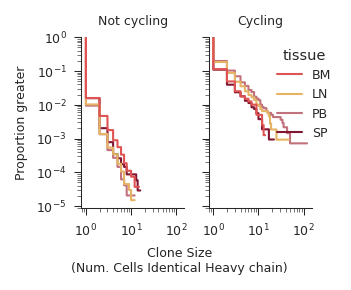

In [35]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(2.4,2))
#sns.set_context('paper')
cycling_cells = vdj_cycling[vdj_cycling['any']==True]
g= sns.ecdfplot(cycling_cells, x='size',
                            hue='tissue',
                            complementary=True,
                            log_scale=(True, True), 
                            ax=ax[1], 
                            palette=get_tissue_colors(), lw=1)
sns.move_legend(g, frameon=False, bbox_to_anchor=(1.3,1.), loc='upper right')
not_cycling_cells = vdj_cycling[vdj_cycling['any']==False]
g=sns.ecdfplot(not_cycling_cells, x='size',
                            hue='tissue',
                            complementary=True,
                            log_scale=(True, True),
                            ax=ax[0], 
                            palette=get_tissue_colors(), lw=1, 
                            legend=False)
ax[0].set_title('Not cycling', fontsize = 6)
ax[1].set_title('Cycling', fontsize = 6)
fig.supxlabel('Clone Size\n(Num. Cells Identical Heavy chain)',y=0.08, fontsize=6)
ax[0].set_xlabel('', )
ax[1].set_xlabel('', )
ax[0].set_ylabel('Proportion greater', fontsize =6 )


sns.despine(fig)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/cycling_expansion_tissue.pdf', bbox_inches='tight')

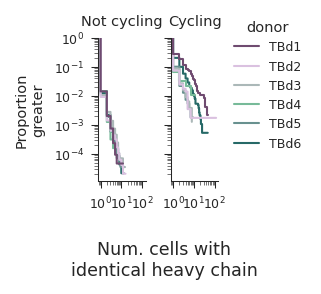

In [36]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(2.2,2))
cycling_cells = vdj_cycling[vdj_cycling['any']==True]
g= sns.ecdfplot(cycling_cells, x='size',
                            hue='donor',
                            complementary=True,
                            log_scale=(True, True), 
                            ax=ax[1], 
                            palette=donor_colors, lw=1)
sns.move_legend(g, frameon=False, bbox_to_anchor=(1.1,1.2), loc='upper left')
not_cycling_cells = vdj_cycling[vdj_cycling['any']==False]
g=sns.ecdfplot(not_cycling_cells, x='size',
                            hue='donor',
                            complementary=True,
                            log_scale=(True, True),
                            ax=ax[0], 
                            palette=donor_colors, lw=1, 
                            legend=False)
ax[0].set_title('Not cycling', )
ax[1].set_title('Cycling', )
fig.supxlabel('Num. cells with\nidentical heavy chain')
ax[0].set_xlabel('', )
ax[1].set_xlabel('', )
ax[0].set_ylabel('Proportion\ngreater', )


sns.despine(fig)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/cycling_expansion_donor.pdf', bbox_inches='tight')

# Cycling Fraction by Donor, Tissue and Sample type

In [37]:
cycling_counts_vdj = vdj_cycling.groupby(['tissue','sample_type','donor','any']).size().reset_index()
cycling_counts_cells = df_clean.groupby(['tissue','sample_type','donor','cycling']).size().reset_index()
fractions_vdj = cycling_counts_vdj.pivot(index='any', columns=['tissue','donor', 'sample_type'], values=0)
fractions_vdj = (fractions_vdj/fractions_vdj.sum()).T
fractions_cells = cycling_counts_cells.pivot(index='cycling', columns=['tissue','donor','sample_type'], values=0)
fractions_cells = (fractions_cells/fractions_cells.sum()).T

In [38]:
kwargs = {'fresh':dict(marker='o', s=10),
          'frozen':dict(marker=(4,1,0), s=18)}

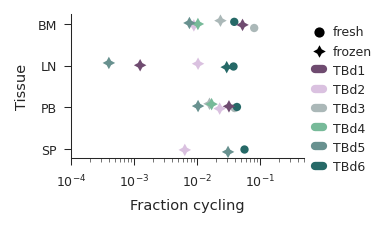

In [39]:
# Create the subplot with swapped dimensions
fig, ax = plt.subplots(figsize=(2, 1.25))

# Update the keyword arguments to reflect the axis swap
kwargs = dict(x=True, 
              y='tissue',
              hue='donor',
              ax=ax, 
              palette=donor_colors,
              legend=False, 
              clip_on=False)

# Iterate over sample types and plot the data with the updated axes
for stype, marker, s in [('fresh', 'o', 4), ('frozen', (4, 1, 0), 6)]:
    subset = fractions_vdj.reset_index().copy()
    subset = subset[subset.sample_type == stype]
    g = sns.stripplot(subset,
                      marker=marker,
                      s=s,
                      **kwargs)
    ax.scatter([], [], color='k', marker=marker, label=stype, s=6 * s, lw=0)

# Set the legend and formatting details
for donor in donor_colors.keys():
    ax.plot([],[],lw=4, color=donor_colors[donor], label=donor)
#ax.scatter([],[], marker='o', label='fresh', color='k')
#ax.scatter([],[], marker=(4,1,0), label='frozen', color='k')
ax.legend(frameon=False, bbox_to_anchor=(1,1), handlelength=0.6)
sns.despine(fig)
ax.yaxis.set_minor_locator(NullLocator())

# Set the axes to log scale and the appropriate limits
ax.set_xscale('log')
ax.set_xlim([10**-4, 0.5])

# Update the labels for the swapped axes
ax.set_xlabel('Fraction cycling')
ax.set_ylabel('Tissue')

# Save the figure with the updated layout
fig.savefig(f'{FIGURE_OUTDIR}/fraction_cycling_sample_prep.pdf', bbox_inches='tight')


# Celltype cycling fraction by Tissue and Sample type

In [40]:
## Subanatomical Location:
cycling_celltypes = df_clean.groupby(['tissue','donor','sample_type','any_cycling', 'celltype']).size().reset_index()
cycling_celltypes = cycling_celltypes.reset_index()
cycling_celltypes = cycling_celltypes.rename(columns={0:'n_cells'})
# ad hoc removal of rare celltypes 
common_celltypes = cycling_celltypes.groupby(['celltype'])['n_cells'].sum() > 20
common_celltypes = common_celltypes[common_celltypes].index.values
print(common_celltypes)
cycling_celltypes = cycling_celltypes[cycling_celltypes.celltype.isin(common_celltypes)]
totals = cycling_celltypes.groupby(['donor','sample_type','tissue','celltype'])['n_cells'].sum()
cycling_celltypes['f_cycling']  = cycling_celltypes.apply(lambda x: x.n_cells/totals[(x.donor, 
                                                                                      x.sample_type,
                                                                                      x.tissue,
                                                                                     x.celltype)],
                                                        axis=1)
# ad hoc collapse of cell type label
cycling_celltypes.loc[:,"celltype"] = cycling_celltypes.celltype.str.replace("Proliferative germinal center B cells",
 'GC B cells')
cycling_celltypes.loc[:,"celltype"] = cycling_celltypes.celltype.str.replace("Germinal center B cells",
'GC B cells')
tissue_list = list(df.tissue.unique())
data = cycling_celltypes[cycling_celltypes.any_cycling == True]

['ABCs' 'ASCs' 'GC B cells' 'Memory B cells' 'Naive B cells']


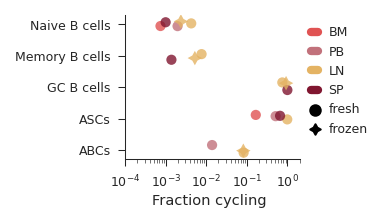

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.25))

# Define a jitter amount
jitter_amount = 0.17

# Get unique categories and create a mapping to numerical values
categories = cycling_celltypes['celltype'].unique()

category_mapping = {category: i for i, category in enumerate(categories)}

for stype, marker, s in [('fresh', 'o', 4), ('frozen', (4, 1, 0), 8)]:
    subset = cycling_celltypes[(cycling_celltypes.donor == donor)
                               & (cycling_celltypes.any_cycling == True)
                               & (cycling_celltypes.sample_type == stype)]
    # Map the y-values to numerical values
    numerical_y = subset['celltype'].map(category_mapping)

    # Apply jitter to the numerical y-values
    jittered_y = numerical_y + np.random.uniform(-jitter_amount, jitter_amount, size=len(subset))

    sns.scatterplot(x='f_cycling',
                    y=jittered_y,
                    hue='tissue',
                    data=subset,
                    ax=ax,
                    palette=tissue_colors,
                    legend=False,
                    marker=marker,
                    linewidth=0,
                    alpha=0.8,
                    s= 6 * s)


for tissue in tissue_list:
    ax.plot([],[],lw=4, color=tissue_colors[tissue], label=tissue)
ax.scatter([],[], marker='o', label='fresh', color='k')
ax.scatter([],[], marker=(4,1,0), label='frozen', color='k')
ax.legend(frameon=False, bbox_to_anchor=(1,1), handlelength=0.6)
# Set the y-tick labels to the original categories
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xscale('log')
ax.set_xlabel('')
ax.yaxis.set_minor_locator(NullLocator())
ax.set_ylabel('')
ax.set_xlim([10**-4, 2])
fig.supxlabel('Fraction cycling', y=-0.15, fontsize=7)
sns.despine(fig)
fig.savefig(f'{FIGURE_OUTDIR}/cycling_fraction_by_celltype.pdf', bbox_inches='tight')


# Broken out by Donor

/tmp/ipykernel_349851/1274500915.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(subset,
/tmp/ipykernel_349851/1274500915.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(subset,
/tmp/ipykernel_349851/1274500915.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(subset,
/tmp/ipykernel_349851/1274500915.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(subset,


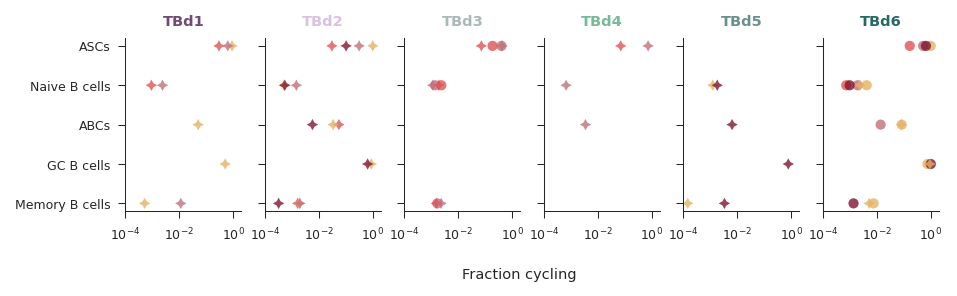

In [42]:
fig, ax = plt.subplots(1,6, sharex=True, sharey=True, figsize=(7,1.5))
ax = ax.flatten()
for i, donor in enumerate(donors):
    for stype, marker, s in [('fresh', 'o', 8), ('frozen', (4, 1, 0), 10)]:
        subset = cycling_celltypes[(cycling_celltypes.donor==donor)
                                  &(cycling_celltypes.any_cycling==True)
                                  & (cycling_celltypes.sample_type==stype)]
        sns.scatterplot(subset, 
                        x='f_cycling', 
                        hue='tissue', 
                        y='celltype', 
                        ax = ax[i], 
                       palette=tissue_colors, 
                       legend=False,
                       marker=marker, 
                       linewidth=0,
                        alpha=0.8,
                       s=3*s)
        # for tissue in subset.tissue.unique():
        #     y=(fractions_cells.loc[(tissue, subset.donor, stype), True].values[0])
        #     ax[i].axvline(x=y,
        #                  color=tissue_colors[tissue])

    ax[i].set_xscale('log')
    ax[i].set_xlabel('', fontsize=9)
    
    ax[i].set_ylabel('')
    ax[i].set_title(donor, color=donor_colors[donor], weight='bold')
    ax[i].set_xlim([10**-4,2])
    ax[i].yaxis.set_minor_locator(NullLocator())

fig.supxlabel('Fraction cycling', fontsize=7, y = -0.2)
# for i in [4,5]:
#     ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

sns.despine(fig)
# fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/donor_cycling_fraction_by_celltype.pdf', bbox_inches='tight')

# Cycling as a function of hypermutation level and tissue

In [43]:
bcell_data = df_clean
# Define the bin edges, stopping at 40
bin_edges = np.arange(0, 60, 4).tolist()  
#bin_edges.append(np.inf)  # Add a last bin for values greater than 40

# Define the labels for the bins, adding a label for the new bin
bin_labels = [0.0] + [round((bin_edges[i] + bin_edges[i + 1]) / 2, 1) for i in range(len(bin_edges) - 2)]
#bin_labels[-1] = '>40'  # Last label for the bin > 0.18

# Cut the data into bins with the new bin edges and labels
bcell_data.loc[:,'bin'] = pd.cut(bcell_data['v_mismatch'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check the value counts for each bin
bcell_value_counts = bcell_data['bin'].value_counts()
print(bcell_value_counts, "number of B cells in each bin")
# Mapping dictionary
mapping_dict = {"Plasma cells": "ASCs", "Plasmablasts": "ASCs", "ASC-1": "ASCs", "ASC-2": "ASCs", "ASC-3":"ASCs", "ASC-4":"ASCs"}
# Applying the mapping to create the 'celltype' column, keeping the original values if they aren't in the dictionary
bcell_data.loc[:,'simple_celltype'] = bcell_data['celltype'].map(lambda x: mapping_dict.get(x, x))

# Group by 'bin' and 'tissue'
grouped = bcell_data.groupby(['bin', 'tissue', "simple_celltype"])

# Calculate the fraction of cells that are cycling and the confidence intervals for each group
def calculate_fraction_and_ci(group, method='beta'):
    count = (group['cycling'] == True).sum()
    n_total = len(group)
    fraction = count / n_total
    lower, upper = proportion_confint(count, n_total, alpha=0.05, method = method)
    return pd.Series({'fraction_cycling': fraction, 'lower_ci': lower, 'upper_ci': upper})

cycling_fractions_per_tissue = grouped.apply(calculate_fraction_and_ci).reset_index()

bin
0.0     102256
6.0      15191
2.0      14043
10.0     13588
14.0     11624
18.0      8823
22.0      6131
26.0      4001
30.0      2583
34.0      1485
38.0       964
42.0       554
46.0       352
50.0       178
Name: count, dtype: int64 number of B cells in each bin


/tmp/ipykernel_349851/1601633842.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = bcell_data.groupby(['bin', 'tissue', "simple_celltype"])
/tmp/ipykernel_349851/1601633842.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cycling_fractions_per_tissue = grouped.apply(calculate_fraction_and_ci).reset_index()


In [44]:
cycling_fractions_per_tissue = cycling_fractions_per_tissue[cycling_fractions_per_tissue.simple_celltype == 'ASCs']

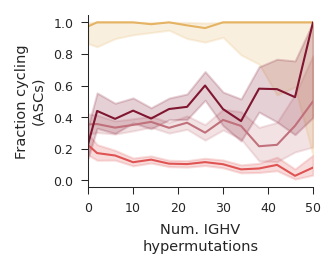

In [45]:
# Create a single plot
fig, ax = plt.subplots(figsize=(2.25, 1.8))

# Iterate through the unique tissues and plot each one with its corresponding color
for tissue in tissue_list:
    # Filter the data for the current tissue
    tissue_data = cycling_fractions_per_tissue[cycling_fractions_per_tissue['tissue'] == tissue]

    # Get the color for the current tissue from the tissue_colors dictionary
    color = tissue_colors[tissue]

    # Plot the points
    sns.lineplot(data=tissue_data, x='bin', y='fraction_cycling', color=color, marker=None, ax=ax, label=tissue)

    # Manually add the filled error bars using plt.fill_between
    x_values = tissue_data['bin']
    ax.fill_between(x_values, tissue_data['lower_ci'], tissue_data['upper_ci'], color=color, alpha=0.2)

# Set labels and title
ax.set_xlabel('Num. IGHV\nhypermutations', fontsize = 7)
ax.set_ylabel('Fraction cycling\n(ASCs)', fontsize = 7)
ax.set_xlim(0,50)
# Add legend to identify tissues
# Remove the legend
ax.legend_.remove()
#ax.legend(title='Tissue')

plt.tight_layout()
sns.despine()
plt.show()

save_figure(fig, "fraction_cycling_by_shm")

# Create publication Figure

In [46]:
def plot_cycling_expansion_tissue(ax0, ax1, cycling_cells, not_cycling_cells, tissue_colors):
    # Plot the ECDF for cycling cells
    sns.ecdfplot(cycling_cells, x='size', hue='tissue', complementary=True, log_scale=(True, True), ax=ax1, palette=tissue_colors, lw=1, legend = False)

    # Plot the ECDF for not cycling cells
    sns.ecdfplot(not_cycling_cells, x='size', hue='tissue', complementary=True, log_scale=(True, True), ax=ax0, palette=tissue_colors, lw=1, legend=False)

    # Set titles and labels
    ax0.set_title('Not cycling', fontsize=6)
    ax1.set_title('Cycling', fontsize=6)
    ax0.set_xlabel('', )
    ax1.set_xlabel('', )
    ax0.set_ylabel('Proportion greater', fontsize=6)


def plot_fraction_cycling_by_shm(ax, cycling_fractions_per_tissue, tissue_colors):
    # Iterate through the unique tissues and plot each one with its corresponding color
    unique_tissues = cycling_fractions_per_tissue['tissue'].unique()
    for tissue in unique_tissues:
        # Filter the data for the current tissue
        tissue_data = cycling_fractions_per_tissue[cycling_fractions_per_tissue['tissue'] == tissue]

        # Get the color for the current tissue from the tissue_colors dictionary
        color = tissue_colors[tissue]

        # Plot the points
        sns.lineplot(data=tissue_data, x='bin', y='fraction_cycling', color=color, marker=None, ax=ax)

        # Manually add the filled error bars using plt.fill_between
        x_values = tissue_data['bin']
        ax.fill_between(x_values, tissue_data['lower_ci'], tissue_data['upper_ci'], color=color, alpha=0.2)

    # Set labels and title
    ax.set_xlabel('Num. IGHV\nhypermutations', fontsize = 6)
    ax.set_ylabel('Fraction cycling\n(ASCs)', fontsize = 6)
    ax.set_xlim(0, 50)

    # Remove the legend
    #ax.legend_.remove()

    # Remove tight_layout() since it will be handled in the main figure
    sns.despine()
    # No need to call plt.show() here



def plot_fraction_cycling_celltype(ax, cycling_celltypes, donor, tissue_colors, tissue_list, jitter_amount=0.15):
    # Get unique categories and create a mapping to numerical values
    categories = cycling_celltypes['celltype'].unique()
    category_mapping = {category: i for i, category in enumerate(categories)}

    # Iterate through sample types and plot the data
    for stype, marker, s in [('fresh', 'o', 3.2), ('frozen', (4, 1, 0), 8.4)]:
        subset = cycling_celltypes[(cycling_celltypes.donor == donor) &
                                   (cycling_celltypes.any_cycling == True) &
                                   (cycling_celltypes.sample_type == stype)]

        # Map the y-values to numerical values and apply jitter
        numerical_y = subset['celltype'].map(category_mapping)
        jittered_y = numerical_y + np.random.uniform(-jitter_amount, jitter_amount, size=len(subset))

        # Plot the scatter plot
        sns.scatterplot(x='f_cycling', y=jittered_y, hue='tissue', data=subset, ax=ax,
                        palette=tissue_colors, legend=False, marker=marker, linewidth=0,
                        alpha=0.8, s=6 * s)

    # Add legend entries
    for tissue in tissue_list:
        ax.plot([], [], lw=4, color=tissue_colors[tissue], label=tissue)
    #ax.scatter([], [], marker='o', label='fresh', color='k')
    #ax.scatter([], [], marker=(4, 1, 0), label='frozen', color='k')
    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), handlelength=0.6)

    # Set y-tick labels and other plot properties
    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories)
    ax.set_xscale('log')
    ax.set_xlabel('Fraction cycling', fontsize = 6) # Set x-label for the axis
    ax.yaxis.set_minor_locator(NullLocator())
    ax.set_ylabel('Tissue', fontsize = 6)
    ax.set_xlim([10**-4, 2])
    sns.despine()


def plot_fraction_cycling_sample_prep(ax, fractions_vdj, donor_colors, FIGURE_OUTDIR):
    # Create the subplot with swapped dimensions
    # Keyword arguments to reflect the axis swap
    kwargs = dict(x=True, 
                    y='tissue',
                    hue='donor',
                    ax=ax, 
                    palette=donor_colors,
                    legend=False, 
                    clip_on=False)

    # Iterate over sample types and plot the data with the updated axes
    for stype, marker, s in [('fresh', 'o', 4), ('frozen', (4, 1, 0), 7)]:
        subset = fractions_vdj.reset_index().copy()
        subset = subset[subset.sample_type == stype]
        sns.stripplot(subset, marker=marker, s=s, **kwargs)
        ax.scatter([], [], color='k', marker=marker, label=stype, s=6 * s, lw=0)

    # Set the legend and formatting details
    for donor in donor_colors.keys():
        ax.plot([], [], lw=4, color=donor_colors[donor], label=donor)

    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), handlelength=0.6)
    sns.despine()
    ax.yaxis.set_minor_locator(NullLocator())

    # Set the axes to log scale and the appropriate limits
    ax.set_xscale('log')
    ax.set_xlim([10**-4, 0.5])

    # Update the labels for the swapped axes
    ax.set_xlabel('Fraction cycling', fontsize = 6)
    ax.set_ylabel('Tissue', fontsize = 6)

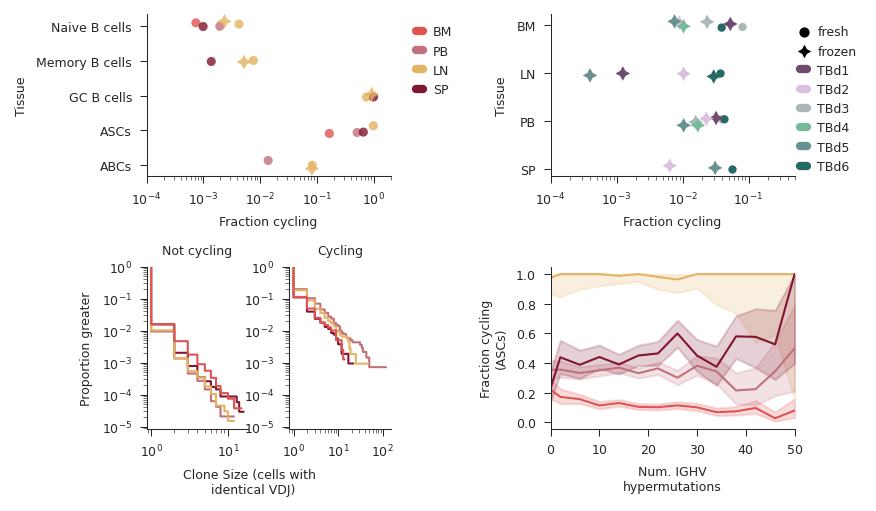

In [47]:
# Create a figure with the desired size
fig = plt.figure(figsize=(6, 3.4))

# Define the main GridSpec layout (2 rows, 2 columns)
gs_main = gridspec.GridSpec(2, 2, width_ratios=[2, 2], height_ratios=[1, 1])

# Create the individual subplots for the first three plots
ax0 = plt.subplot(gs_main[0, 0]) # Top left
ax1 = plt.subplot(gs_main[0, 1]) # Top middle
ax2 = plt.subplot(gs_main[1, 1]) # Bottom left, sharing x-axis with top left

# Create a nested GridSpec for ax3 and ax4
gs_nested = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[1, 0], wspace=0.4, width_ratios=[1, 1])

ax3 = plt.subplot(gs_nested[0]) # Bottom middle
ax4 = plt.subplot(gs_nested[1], sharey=ax3) # Bottom right, sharing y-axis with bottom middle

# Call the plot functions for each subplot, with the appropriate arguments
plot_fraction_cycling_sample_prep(ax1, fractions_vdj, donor_colors, FIGURE_OUTDIR)
plot_fraction_cycling_celltype(ax0, cycling_celltypes, donor, tissue_colors, tissue_list)
plot_fraction_cycling_by_shm(ax2, cycling_fractions_per_tissue, tissue_colors)
plot_cycling_expansion_tissue(ax3, ax4, cycling_cells, not_cycling_cells, tissue_colors)

# Remove y-axis labels and ticks from ax4
#ax4.set_yticks([])
#ax4.set_yticklabels([])
ax4.set_ylabel("")
#ax3.set_xlabel("Clone Size (cells with identical VDJ)", size = 6)
fig.text(0.28, 0.03, "Clone Size (cells with \n identical VDJ)", ha='center', size = 6)
# Adjust the layout
plt.tight_layout()
sns.despine()
plt.show()


In [24]:
save_figure(fig, "EDFigure1")